In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
image_size = [224,224]
data_path = 'Data/Training'

In [3]:
vgg = VGG16(input_shape= image_size+[3],weights='imagenet',include_top=False)

In [4]:
x = vgg.output
x = GlobalAveragePooling2D()(x)

In [5]:
x = Dense(1024,activation='relu')(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512, activation='relu')(x)
x= Dense(256,activation='relu')(x)

In [6]:
preds = Dense(2,activation='softmax')(x)

In [8]:
model = Model(inputs = vgg.input,outputs=preds)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
# for layer in vgg.layers[:20]:
#     layer.trainable=False
# for layer in vgg.layers[20:]:
#     layer.trainable = True

In [14]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
for layer in vgg.layers:
    layer.trainable = False

In [16]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('/content/drive/My Drive/Dataset/Data/Training/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=7,
                                                 class_mode='categorical',
                                                 shuffle=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/Dataset/Data/Test/',
        target_size=(224, 224),
        color_mode='rgb',
        batch_size=3,
        class_mode='categorical',shuffle=False)

Found 2177 images belonging to 2 classes.
Found 831 images belonging to 2 classes.


In [0]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
print(train_generator.class_indices,np.unique(train_generator.labels,return_counts=True))
print(test_generator.class_indices,np.unique(test_generator.labels,return_counts=True))

{'no': 0, 'yes': 1} (array([0, 1], dtype=int32), array([1058, 1119]))
{'no': 0, 'yes': 1} (array([0, 1], dtype=int32), array([362, 469]))


In [19]:
print(train_generator.n)
print(train_generator.batch_size)
print(train_generator.n//train_generator.batch_size)

2177
7
311


In [21]:
step_size_train=train_generator.n//train_generator.batch_size
r = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=20)
from tensorflow.keras.models import load_model
model.save('/content/drive/My Drive/Dataset/Latest_brain_tumor_NEW.h5')

Epoch 1/20
311/311 [==============================] - 887s 3s/step - loss: 0.2872 - acc: 0.8888
Epoch 2/20
311/311 [==============================] - 35s 114ms/step - loss: 0.1474 - acc: 0.9518
Epoch 3/20
311/311 [==============================] - 35s 114ms/step - loss: 0.0803 - acc: 0.9738
Epoch 4/20
311/311 [==============================] - 35s 113ms/step - loss: 0.0857 - acc: 0.9711
Epoch 5/20
311/311 [==============================] - 35s 113ms/step - loss: 0.0534 - acc: 0.9738
Epoch 6/20
311/311 [==============================] - 35s 113ms/step - loss: 0.0308 - acc: 0.9867
Epoch 7/20
311/311 [==============================] - 35s 113ms/step - loss: 0.0912 - acc: 0.9747
Epoch 8/20
311/311 [==============================] - 35s 113ms/step - loss: 0.0299 - acc: 0.9881
Epoch 9/20
311/311 [==============================] - 35s 113ms/step - loss: 0.0255 - acc: 0.9890
Epoch 10/20
311/311 [==============================] - 35s 113ms/step - loss: 0.0228 - acc: 0.9913
Epoch 11/20
311/311 [

In [0]:
#step_size_valid=test_generator.n//test_generator.batch_size
#scores=model.evaluate_generator(generator=test_generator,
#steps=step_size_valid)
#print('Loss =, Accuracy = ',scores[0],scores[1])

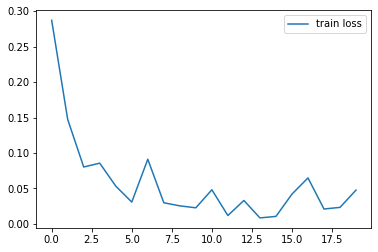

<Figure size 432x288 with 0 Axes>

In [22]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
# plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


In [0]:
######################## PREDICTION #########################

In [23]:
step_size_test=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=step_size_test,
verbose=1)

277/277 [==============================] - 355s 1s/step


In [0]:
scores=np.max(pred,axis=1)

In [25]:
predicted=np.argmax(pred,axis=1)
actual=test_generator.classes
from sklearn.metrics import accuracy_score
print(accuracy_score(predicted,actual))

0.9927797833935018


In [0]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds=roc_curve(actual, scores,pos_label=1)

No handles with labels found to put in legend.


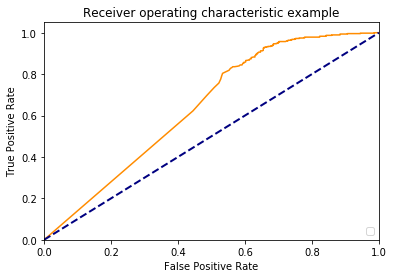

In [40]:
import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='darkorange'
         )
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [0]:
######################## PREDICTION of 1 individual image #########################

In [0]:
img_path = 'Data/Training/no/15 no.jpg'
img = image.load_img(img_path,target_size=(224,224))
x1= image.img_to_array(img)
x = np.expand_dims(x1,axis=0)
img_data = preprocess_input(x)

In [0]:
rslt = model.predict(img_data)
print(rslt)

In [0]:
if rslt[0][0] == 1:
    prediction = 'Not A Brain Tumor'
else:
    prediction = 'Brain Tumor'
    
print(prediction)